In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def evaluate(model,x_train, y_train, x_test, y_test):
    model.fit(x_train,y_train)
    
    y_test_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)
    
    Rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    R2_score_train = r2_score(y_train, y_train_pred)
    R2_score_test = r2_score(y_test, y_test_pred)
    return Rmse, R2_score_train, R2_score_test

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector

scaler = ['-',MinMaxScaler(), StandardScaler(), RobustScaler()]


def rate_model(model):
    n = 45
    i = 0
# RESET TABLE
    rate_table = pd.DataFrame({'Model': ['-'],'FeatureSelection':['-'] ,'Scaler': ['-'], 'Number of features': ['-']
                            ,'Rmse':['-'], 'R2 Score(train)':['-'], 'R2 Score(test)':['-']})
# Original:
    Rmse, R2_score_train, R2_score_test = evaluate(model,X_train,y_train,X_test,y_test)
    num_feats = X_train.shape[1]
    row = pd.DataFrame({'Model':model, 'FeatureSelection': ['-'], 'Scaler': ['-'],
                                'Number of features': num_feats,'Rmse':Rmse, 'R2 Score(train)':R2_score_train, 
                                'R2 Score(test)':R2_score_test})
    rate_table = pd.concat([rate_table,row],axis = 0,ignore_index=True)
    
    sys.stdout.write("\rProgress: [{:<30}] {:.2f}%".format("=" * (i // 2), (i / n) * 100))
    i+=1
    sys.stdout.write("\rProgress: [{:<30}] {:.2f}%\tDone original!".format("=" * (i // 2), (i / n) * 100))
#varianceThreshold:
    threshold = [0.05, 0.5,1]
    for thres in threshold:
        selector = VarianceThreshold(threshold=thres)
        x_train = selector.fit_transform(X_train)
        x_test = selector.transform(X_test)
        num_feats = x_train.shape[1]
        for sc in scaler:
            if sc != '-':
                x_train = sc.fit_transform(x_train)
                x_test = sc.transform(x_test)
            Rmse, R2_score_train, R2_score_test = evaluate(model,x_train,y_train,x_test,y_test)
            row = pd.DataFrame({'Model':model, 'FeatureSelection': ['VarianceThreshold'], 'Scaler': sc,
                                'Number of features': num_feats,'Rmse':Rmse, 'R2 Score(train)':R2_score_train, 
                                'R2 Score(test)':R2_score_test})
            rate_table = pd.concat([rate_table,row],axis = 0,ignore_index=True)
            sys.stdout.write("\rProgress: [{:<30}] {:.2f}%!".format("=" * (i // 2), (i / n) * 100))
            sys.stdout.flush()
            i+=1
    sys.stdout.write("\rProgress: [{:<30}] {:.2f}%\tDone varThreshold!".format("=" * (i // 2), (i / n) * 100))
    
    
#selectKbest
    num_bests = [19,16,12,7]
    for num in num_bests:
        selection = [(["SelectKBest"],SelectKBest(score_func = f_classif, k=num)),
                     #(["RFE"],RFE(model,n_features_to_select=num)),
                     (["SFS"],SequentialFeatureSelector(model,n_features_to_select=num,scoring='r2',cv=3))]
        for name, selector in selection:
            x_train = selector.fit_transform(X_train,y_train)
            x_test = selector.transform(X_test)
            num_feats = x_train.shape[1]
            for sc in scaler:
                if sc != '-':
                    x_train = sc.fit_transform(x_train)
                    x_test = sc.transform(x_test)
                Rmse, R2_score_train, R2_score_test = evaluate(model,x_train,y_train,x_test,y_test)
                row = pd.DataFrame({'Model':model, 'FeatureSelection': name, 'Scaler': sc,
                                    'Number of features': num_feats,'Rmse':Rmse, 'R2 Score(train)':R2_score_train, 
                                    'R2 Score(test)':R2_score_test})
                rate_table = pd.concat([rate_table,row],axis = 0,ignore_index=True)
                sys.stdout.write("\rProgress: [{:<30}] {:.2f}%".format("=" * (i // 2), (i / n) * 100))
                sys.stdout.flush()
                i+=1
        
        sys.stdout.write("\rProgress: [{:<30}] {:.2f}%\tDone num_feat = {}!".format("=" * (i // 2), (i / n) * 100,num))   
        
    rate_table = rate_table.iloc[1:].sort_values(by='R2 Score(test)',ascending=False)
    display(rate_table)
    rate_table.to_csv(f'{model}', index=False)

In [5]:
df = pd.read_csv("kc_house_data.csv")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['age'] = df['year'] - df['yr_built']
df = df.drop(labels=["date","yr_built"],axis=1)

from sklearn.model_selection import train_test_split

x = df.drop(labels='price',axis=1)
y = df['price']
X_1, X_test, y_1, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [6]:
model = xgb.XGBRegressor(objective ='reg:squarederror', 
                         colsample_bytree = 0.3,
                         learning_rate = 0.1,
                         max_depth = 5,
                         alpha = 10,
                         n_estimators = 100)

In [7]:
model.fit(X_train,y_train)
y_val_pred = model.predict(X_val)
r2_score(y_val, y_val_pred)


0.8803274991898061

In [8]:
model.fit(X_train,y_train)
y_test_pred = model.predict(X_test)
r2_score(y_test, y_test_pred)

0.8682431692831941

In [9]:
y_train_pred = model.predict(X_train)
r2_score(y_train, y_train_pred)

0.9384088679183179

# Regularzation

: là kỹ thuật dùng để kiểm soát overfitting và tối ưu hóa hiệu suất của mô hình, ngăn chặn việc học thuộc của mô hình mà không tạo ra quy luật tổng quát

## Lasso Regression

Least Absolute Shrinkage and Selection Operator: Thêm 1 thành phần giá trị tuyệt đối.

**HÀM MẤT MÁT**:

<font size = 5> $L = \frac{1}{n}\sum_{i=1}^n (y_i-\hat{y_i} ) ^2 + \lambda \sum_{i=1}^m |w_i| $

* m - Number of features
* n - number of Examples
* $y_i$ - Acutal Target Value
* $\hat{y_i}$  - Predicted Target Value

## Ridge Regression

Thêm 1 thành phần bình phương.

**HÀM MẤT MÁT:**

<font size = 5> $ L = \frac{1}{n} \sum_{i=1}^n(y_i - \hat{y_i})^2 + \lambda \sum_{i=1}^m w_i^2 $

Ý nghĩa: Kiểm soát Overfitting, Lựa chọn đặc trưng. Giảm độ lớn của hệ số, tăng hiệu suất cho dl nh, giảm nhiều. Ứng dụng no môi hinh tuyến tính.

# XGBoost

là Extreme Gradient Boost bằng cách sử dụng:
* Regularization
* Cross-validation

## How it works:

In [400]:
np.random.seed(42)
X = np.random.rand(20, 1) * 10  
y =  X.squeeze()**2 + np.random.randint(low=-10,high=10,size=20)

In [401]:
df = pd.DataFrame({'X':X.reshape(-1),'y': y})
df = df.sort_values(by='X').reset_index(drop=True)


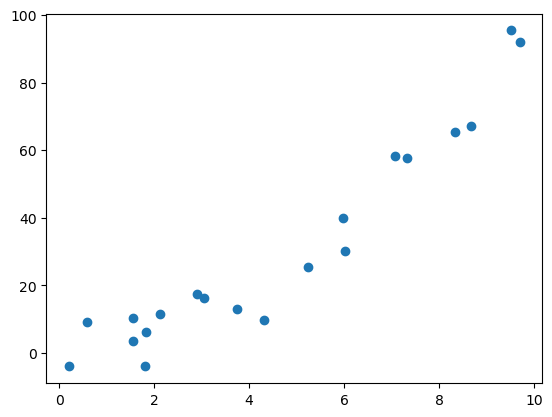

In [402]:
plt.scatter(X,y)

**Default** predict line is 0.5:

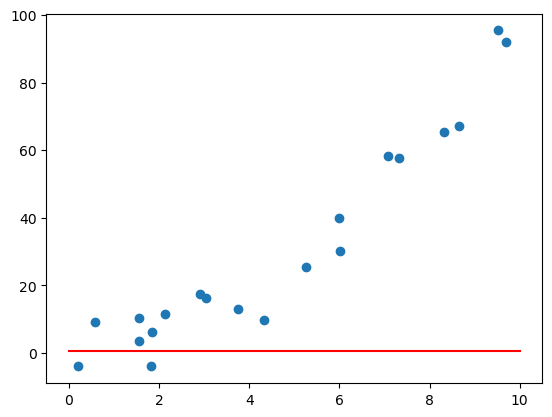

In [403]:
plt.scatter(X,y)
plt.plot([0,10],[0.5,0.5],c='r')

**Count residuals**

In [404]:
r = y - 0.5

**Count similarity Score** with lambda = 0


<font size = 5> Similarity Score = $\frac{Sum_{of} r,squared}{Number_{of} r + \lambda}$

In [405]:
Simi = (np.sum(r)**2)/len(r)
Simi

18657.378811693077

In [396]:
df

,X,y,r,pred_custom,pred_lib
0,0.205845,-3.957628,-4.457628,2.800437,1.310733
1,0.580836,9.337371,8.837371,2.800437,1.310733
2,1.559945,3.433429,2.933429,2.800437,1.310733
3,1.560186,10.434182,9.934182,2.800437,1.310733
4,1.818250,-3.693968,-4.193968,2.800437,1.310733
5,1.834045,6.363721,5.863721,2.800437,1.310733
6,2.123391,11.508790,11.008790,2.800437,4.377251
7,2.912291,17.481441,16.981441,2.800437,4.377251
8,3.042422,16.256334,15.756334,2.800437,4.377251
9,3.745401,13.028030,12.528030,2.800437,4.377251


In [406]:
y = df.y
np.sum(y-0.5)**2/20

18657.378811693077

In [408]:
Y_left,Y_right

(0   -3.957628
 Name: y, dtype: float64,
 1      9.337371
 2      3.433429
 3     10.434182
 4     -3.693968
 5      6.363721
 6     11.508790
 7     17.481441
 8     16.256334
 9     13.028030
 10     9.657650
 11    25.536931
 12    39.839198
 13    30.133926
 Name: y, dtype: float64)

In [407]:
y = df.iloc[0:14,1]
split = 0
Y_left = y[:split+1]
Y_right = y[split+1:] 
Simi_left = ((np.sum(Y_left))**2)/len(Y_left)
Simi_right = ((np.sum(Y_right))**2)/len(Y_right)
Simi_left,Simi_right

(15.662818273962921, 2756.9953595867873)

In [393]:
def count_Simi(split,y):
    Y_left = y[:split]
    Y_right = y[split:] 
    Simi_left = ((np.sum(Y_left))**2)/len(Y_left)
    Simi_right = ((np.sum(Y_right))**2)/len(Y_right)
    return Simi_left,Simi_right

In [409]:
def Gain(x,y,start=0):
    split = []
    gain = np.zeros(len(x)-1)
    for i in range(len(x)-1):
        split.append(i)
        simi_left,simi_right = count_Simi(split[i]+1,y)
        gain[i] = simi_left + simi_right - Simi
        if max(gain) <0:
            return gain,0
        best_split = np.argmax(gain)
    return gain,best_split+start

In [410]:
gain_2_left,split_2_left = Gain(df.iloc[0:14,0],df.iloc[0:14,1])
gain_2_left,split_2_left


(array([-15884.72063383, -15943.51803453, -15797.98149532, -15805.4422244 ,
        -15405.21003021, -15238.14569414, -15200.08135976, -15320.5410275 ,
        -15362.11480818, -15249.2463626 , -14882.7547237 , -15099.76025576,
        -15895.86763744]),
 0)

**First Split**:

In [254]:
split_1 = (df.X[0] + df.X[1])/2

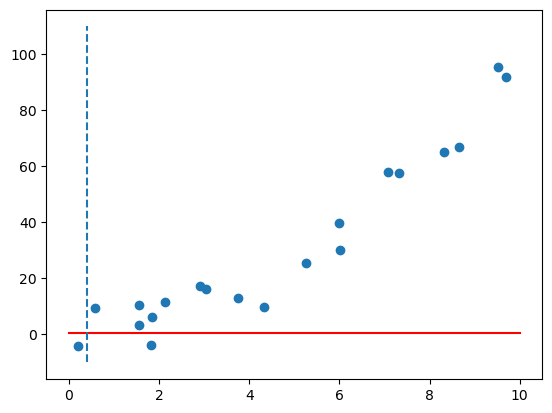

In [18]:
plt.scatter(X,y)
plt.plot([0,10],[0.5,0.5],c='r')
plt.plot([split_1,split_1],[-10,110],ls='--')


In [411]:
simi_1_left,simi_1_right = count_Simi(1,df.y)
simi_1_left,simi_1_right

(15.662818273962921, 20547.086879831826)

=> Gain: simi_1_left + simi_1_right - simi_root = 

In [256]:
gain_1 = simi_1_left + simi_1_right - Simi
gain_1

1905.3708864127111

**Second split**:

In [257]:
split_2 = (df.X[1] + df.X[2])/2

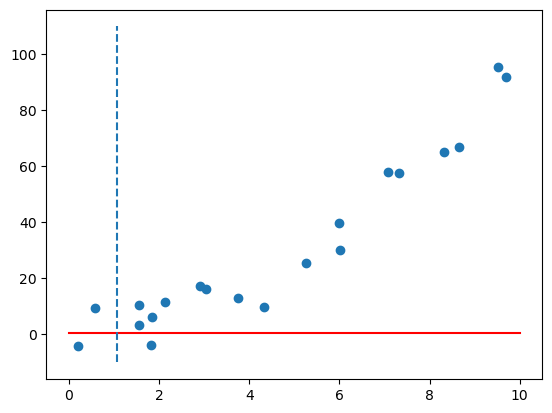

In [22]:
plt.scatter(X,y)
plt.plot([0,10],[0.5,0.5],c='r')
plt.plot([split_2,split_2],[-10,110],ls='--')


In [258]:
simi_2_left,simi_2_right = count_Simi(2,df.y)

gain_2 = simi_2_left + simi_2_right - Simi
gain_2

2402.2901061913617

**Third split**:

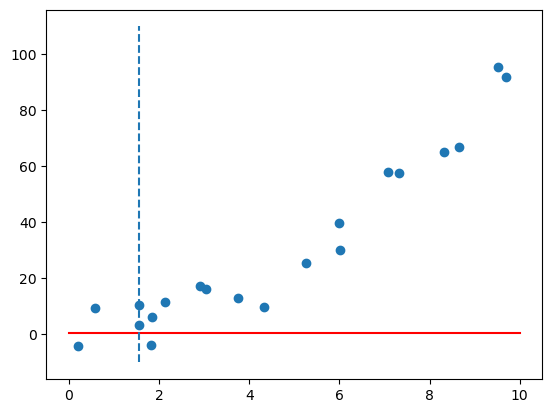

In [259]:
split_3 = (df.X[2] + df.X[3])/2
plt.scatter(X,y)
plt.plot([0,10],[0.5,0.5],c='r')
plt.plot([split_3,split_3],[-10,110],ls='--')


In [260]:
simi_3_left,simi_3_right = count_Simi(3,df.y)

gain_3 = simi_3_left + simi_3_right - Simi
gain_3

3403.744323221119

In [425]:
gain,best_split = Gain(df.X,df.y)
gain,best_split

(array([ 1905.37088641,  2402.29010619,  3403.74432322,  4056.20190188,
         5817.25314439,  7046.27198654,  8046.58437438,  8736.88516504,
         9714.51897332, 11217.70376211, 13406.54995428, 14389.83606438,
        14169.46510665, 15406.6188214 , 13775.7236786 , 12572.99059408,
        10825.91942497,  9348.22331129,  4536.50349397]),
 13)

ValueError: x and y must be the same size

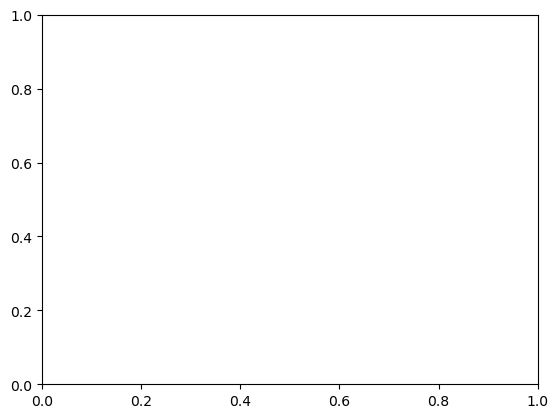

In [413]:
split = (df.X[best_split] + df.X[best_split+1])/2
plt.scatter(X,y)
plt.plot([0,10],[0.5,0.5],c='r')
plt.plot([split,split],[-10,110],ls='--')

In [414]:
gain_2_left,split_2_left = Gain(df.iloc[0:14,0],df.iloc[0:14,1])
gain_2_left,split_2_left


(array([-15884.72063383, -15943.51803453, -15797.98149532, -15805.4422244 ,
        -15405.21003021, -15238.14569414, -15200.08135976, -15320.5410275 ,
        -15362.11480818, -15249.2463626 , -14882.7547237 , -15099.76025576,
        -15895.86763744]),
 0)

In [415]:
gain_2_right,split_2_right = Gain(df.iloc[14:,0],df.iloc[14:,1],14)

In [416]:
gain_2_right,split_2_right

(array([13202.9074096 , 13602.85792939, 13852.1113919 , 14293.9319965 ,
        13408.27229062]),
 17)

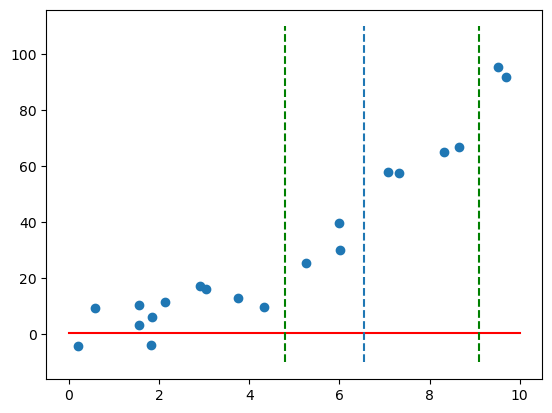

In [270]:
slice_1 = (df.X[best_split] + df.X[best_split+1])/2
slice_2_right = (df.X[split_2_right] + df.X[split_2_right+1])/2
slice_2_left = (df.X[split_2_left] + df.X[split_2_left+1])/2

plt.scatter(X,y,)
plt.plot([0,10],[0.5,0.5],c='r')
plt.plot([slice_1,slice_1],[-10,110],ls='--')
plt.plot([slice_2_right,slice_2_right],[-10,110],ls='--',c='g')
plt.plot([slice_2_left,slice_2_left],[-10,110],ls='--',c='g')

**SPLIT**

<img src='https://scontent-hkg4-2.xx.fbcdn.net/v/t1.15752-9/387477733_1521582425267589_1976177021321059686_n.png?_nc_cat=109&ccb=1-7&_nc_sid=8cd0a2&_nc_ohc=H3wiSAVRkUIAX8vZq3p&_nc_ht=scontent-hkg4-2.xx&oh=03_AdRScfJeP4M8_wGyGtuJKxrhF1_pjJG5YNJ8TLEEOC9v-g&oe=658CCA56' style="width:1000px;"/>

**Out put**

<font size = 5> Output Value = $ \frac{Sum_{of}Residuals}{Number_{of}Residuals + \lambda}$

In [417]:
r_1 = df.iloc[:11,1] - 0.5
Output_1 = np.sum(r_1)/(len(r_1))
Output_1

7.668122900580963

In [418]:
r_2 = df.iloc[11:14,1] - 0.5
Output_2 = np.sum(r_2)/(len(r_2))
Output_2

31.33668501945104

In [419]:
r_3 = df.iloc[14:18,1] - 0.5
Output_3 = np.sum(r_3)/(len(r_3))
Output_3

61.51009430019093

In [420]:
r_4 = df.iloc[18:,1] - 0.5
Output_4 = np.sum(r_4)/(len(r_4))
Output_4

93.22914068666947

**Output residuals**

<img src='https://scontent-hkg4-1.xx.fbcdn.net/v/t1.15752-9/401230483_879573893827852_8522923867221723520_n.png?_nc_cat=102&ccb=1-7&_nc_sid=8cd0a2&_nc_ohc=ROnrgrq7BjoAX9v28D7&_nc_ht=scontent-hkg4-1.xx&oh=03_AdQcTYE75Y42w3P3MR9itKXhyrtP7cPP1H0qTPoGfEPFrQ&oe=658CBACB' style="width:800px;"/> 

**Predict line**

<font size = 5> Pred = Old Pred + Learning rate*Output

In [344]:
# learning rate default = 0.3
pred_1 = 0.5 + 0.3*Output_1
pred_2 = 0.5 + 0.3*Output_2
pred_3 = 0.5 + 0.3*Output_3
pred_4 = 0.5 + 0.3*Output_4

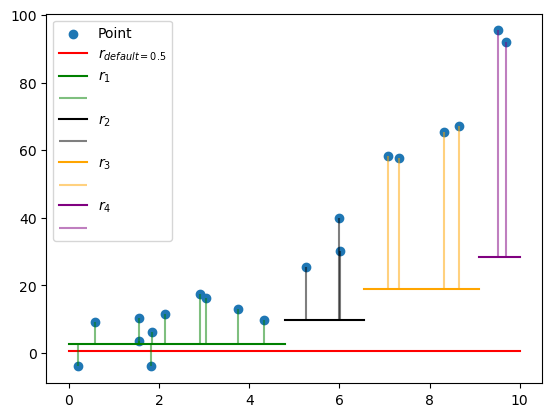

In [286]:
plt.scatter(X,y,)

plt.plot([0,10],[0.5,0.5],c='r')

plt.plot([0,(df.X[10]+df.X[11])/2],[pred_1,pred_1],c='g')
plt.vlines(df[df.X <5.24]['X'], pred_1, df[df.X <5.24]['y'], colors='green',alpha=0.5)

plt.plot([(df.X[10]+df.X[11])/2,(df.X[13]+df.X[14])/2],[pred_2,pred_2],c='black')
plt.vlines(df.iloc[11:14,0], pred_2, df.iloc[11:14,1], colors='black',alpha=0.5)

plt.plot([(df.X[13]+df.X[14])/2,(df.X[17]+df.X[18])/2],[pred_3,pred_3],c='orange')
plt.vlines(df.X[14:18], pred_3, df.y[14:18], colors='orange',alpha=0.5)


plt.plot([(df.X[17]+df.X[18])/2,10],[pred_4,pred_4],c='purple')
plt.vlines(df.iloc[18:,0], pred_4, df.iloc[18:,1], colors='purple',alpha=0.5)

plt.legend(labels=['Point','$r_{default=0.5}$','$r_1$','','$r_2$','','$r_3$','','$r_4$',''])


In [354]:
np.sum(abs(r))

628.161257517791

In [357]:
r1 = np.sum(abs(pred_1 - df[df.X <5.25]['y']))
r2 = np.sum(abs(pred_2 - df.iloc[12:14,1]))
r3 = np.sum(abs(pred_3 - df.y[14]))
r4 = np.sum(abs(pred_4 - df.iloc[15:,1]))
r1+r2+r3+r4

432.6590122246646

In [356]:
r1+r2+r3+r4

432.6590122246646

In [358]:
df_pred = pd.DataFrame(df)
df_pred['r'] = df.y - 0.5
# df_pred['pred_custom'] =df[df.X <5.25]['y'] - pred_1
# df_pred.iloc[12:14,3] = df.iloc[12:14,1] - pred_2
# df_pred.pred_custom[14] = df.y[14] - pred_3 
# df_pred.iloc[15:,3] = df.iloc[15:,1] - pred_4

df_pred['pred_custom'] =pred_1
df_pred.iloc[11:14,3] =  pred_2
df_pred.iloc[14:18,3] =  pred_3 
df_pred.iloc[18:,3] =  pred_4

In [346]:
print('RMSE:' ,np.sqrt(mean_squared_error(df.y, df_pred.pred_custom)),
      '\nR2 score:',r2_score(df.y, df_pred.pred_custom))

RMSE: 30.319712782935515 
R2 score: -0.013295497775789977


In [422]:
model = xgb.XGBRegressor(objective ='reg:squarederror',max_depth = 2,max_leaves=2,n_estimators = 1)
model.fit(df.X,df.y)
y_pred = model.predict(df.X)
print('RMSE:' ,np.sqrt(mean_squared_error(df.y, y_pred)),
      '\nR2 score:',r2_score(df.y, y_pred))

RMSE: 32.66158370038846 
R2 score: -0.17587301871516403


In [423]:
df_pred['pred_lib'] = y_pred

In [424]:
df_pred

,X,y,r,pred_custom,pred_lib
0,0.205845,-3.957628,-4.457628,2.800437,1.310733
1,0.580836,9.337371,8.837371,2.800437,1.310733
2,1.559945,3.433429,2.933429,2.800437,1.310733
3,1.560186,10.434182,9.934182,2.800437,1.310733
4,1.818250,-3.693968,-4.193968,2.800437,1.310733
5,1.834045,6.363721,5.863721,2.800437,1.310733
6,2.123391,11.508790,11.008790,2.800437,4.377251
7,2.912291,17.481441,16.981441,2.800437,4.377251
8,3.042422,16.256334,15.756334,2.800437,4.377251
9,3.745401,13.028030,12.528030,2.800437,4.377251


In [426]:
model.__class__.__name__

'XGBRegressor'